In [1]:
import torch
import datasets, networks
import matplotlib.pyplot as plt
from torch import nn

In [2]:
#HYPERPARAMETERS
num_epochs = 9

# TODO Select a optimizer. [ 'adam', 'adamw', 'rmsprop' ]
optimizer_option = 'adam'

# TODO Select a lr scheduler. [ 'step', 'cosine', 'exponential']
lr_scheduler_option = 'step'

# TODO Select a batch size.
batch_size = 64

# TODO Select a learning rate.
lr = 0.001


num_layers = 3
res_num = 5
channels = 128

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

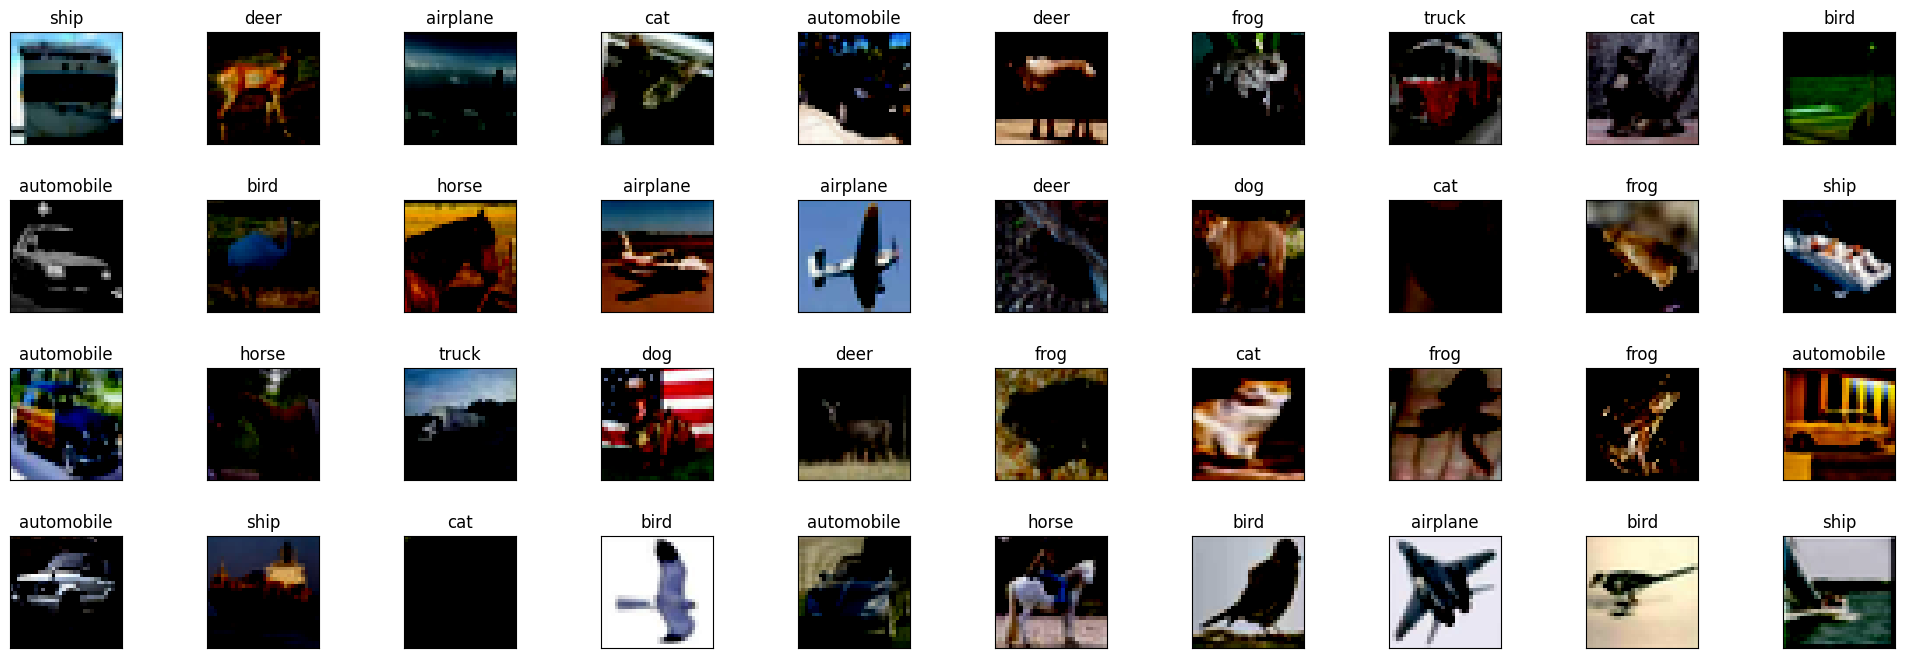

In [3]:
ds = datasets.Dataset('cifar10', batch_size=batch_size)
training_data = ds.get_train_data_loader()
test_data = ds.get_test_data_loader()

ds.visualize_dataset(training_data)